In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc=None, test_size=0.1)

# ResNet50 Layer Transfer

## Using Flatten

In [3]:
model_name = 'ResNet50-Layer-Transfer'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
166/167 [============================>.] - ETA: 0s - loss: 3.5760 - acc: 0.0772
Epoch 00001: val_loss improved from inf to 3.08163, saving model to ./saved_models/ResNet50-Layer-Transfer.h5
167/167 [==============================] - 29s 173ms/step - loss: 3.5762 - acc: 0.0767 - val_loss: 3.0816 - val_acc: 0.0736
Epoch 2/100
166/167 [============================>.] - ETA: 0s - loss: 3.2084 - acc: 0.0999
Epoch 00002: val_loss improved from 3.08163 to 3.06511, saving model to ./saved_models/ResNet50-Layer-Transfer.h5
167/167 [==============================] - 22s 134ms/step - loss: 3.2081 - acc: 0.1000 - val_loss: 3.0651 - val_acc: 0.0736
Epoch 3/100
166/167 [============================>.] - ETA: 0s - loss: 2.9964 - acc: 0.1241
Epoch 00003: val_loss did not improve from 3.06511
167/167 [==============================] - 22s 131ms/step - loss: 2.9959 - acc: 0.1233 - val_loss: 3.0773 - val_acc: 0.0970
Epoch 4/100
166/167 [============================>.] - ETA: 0s - loss: 2.7994

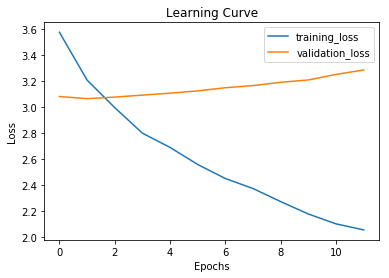

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

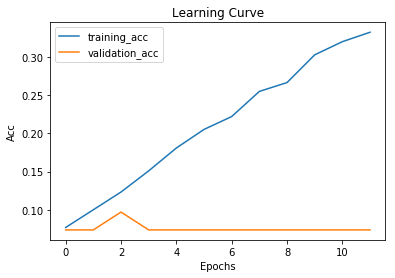

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 5ms/step
Validation loss: 3.0651076980259107
Validation accuracy: 0.0735785955170724


## Using GlobalAveragePooling2D

In [8]:
model_name = 'ResNet50-Layer-Transfer-GlobalAveragePooling2D'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
166/167 [============================>.] - ETA: 0s - loss: 3.7353 - acc: 0.0637
Epoch 00001: val_loss improved from inf to 2.85053, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
167/167 [==============================] - 35s 211ms/step - loss: 3.7319 - acc: 0.0637 - val_loss: 2.8505 - val_acc: 0.0502
Epoch 2/100
166/167 [============================>.] - ETA: 0s - loss: 3.1757 - acc: 0.1011
Epoch 00002: val_loss improved from 2.85053 to 2.81065, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
167/167 [==============================] - 23s 136ms/step - loss: 3.1773 - acc: 0.1009 - val_loss: 2.8106 - val_acc: 0.0468
Epoch 3/100
166/167 [============================>.] - ETA: 0s - loss: 2.9461 - acc: 0.1205
Epoch 00003: val_loss improved from 2.81065 to 2.79964, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
167/167 [==============================] - 22s 134ms/step - loss: 2.9

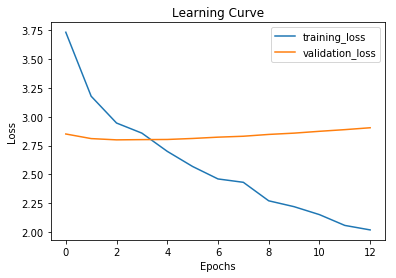

In [10]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

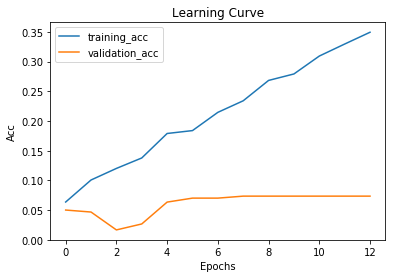

In [11]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [12]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 6ms/step
Validation loss: 2.7996381756454007
Validation accuracy: 0.016722408026755852


# ResNet50 Fine Tuning

In [13]:
model_name = 'ResNet50-Fine-Tuning'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
166/167 [============================>.] - ETA: 0s - loss: 3.4782 - acc: 0.1090
Epoch 00001: val_loss improved from inf to 3.12792, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
167/167 [==============================] - 77s 459ms/step - loss: 3.4757 - acc: 0.1091 - val_loss: 3.1279 - val_acc: 0.0435
Epoch 2/100
166/167 [============================>.] - ETA: 0s - loss: 2.4992 - acc: 0.2570
Epoch 00002: val_loss improved from 3.12792 to 2.97151, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
167/167 [==============================] - 29s 174ms/step - loss: 2.4983 - acc: 0.2581 - val_loss: 2.9715 - val_acc: 0.0502
Epoch 3/100
166/167 [============================>.] - ETA: 0s - loss: 1.8262 - acc: 0.4259
Epoch 00003: val_loss improved from 2.97151 to 1.96318, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
167/167 [==============================] - 29s 176ms/step - loss: 1.8232 - acc: 0.4268 - val_loss: 1.9632 - val_acc: 0.3177
Epoch 4/100
166/167 [==

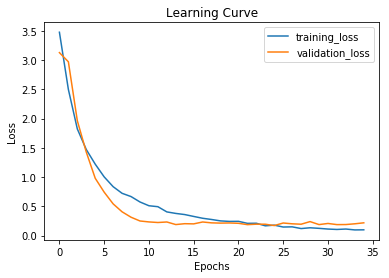

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

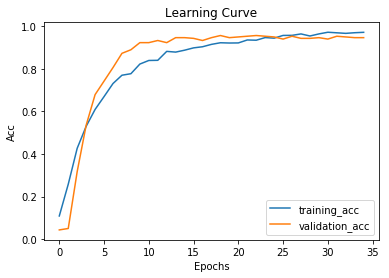

In [16]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [17]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 4s 12ms/step
Validation loss: 0.16998983984408172
Validation accuracy: 0.9498327759197325
